In [1]:
import pandas as pd                                     # type: ignore
import numpy as np                                      # type: ignore
import warnings                                         # type: ignore
from sklearn.model_selection import train_test_split    # type: ignore
from sklearn.decomposition import PCA                   # type: ignore
from sklearn.preprocessing import StandardScaler, MinMaxScaler# type: ignore
from sklearn.model_selection import GridSearchCV, StratifiedKFold # type: ignore
from sklearn.metrics import confusion_matrix,f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, make_scorer# type: ignore
import tensorflow as tf                                 # type: ignore
from tensorflow import keras                            # type: ignore
from keras.layers import Dense, Dropout                 # type: ignore
from keras.optimizers import Adam, SGD                  # type: ignore
from keras.callbacks import EarlyStopping               # type: ignore
import matplotlib.pyplot as plt                         # type: ignore
from imblearn.over_sampling import RandomOverSampler, SMOTE# type: ignore
from imblearn.under_sampling import TomekLinks          # type: ignore
from scipy import stats  

warnings.filterwarnings(action='ignore')

tf.config.set_visible_devices([], 'GPU')

In [2]:
# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
RISK_FREE = 1.03
origin_train_df = pd.read_csv("scaled_train.csv")
origin_test_df = pd.read_csv("scaled_test.csv")
fold_train_df = None

def get_expected_train_roe(val_index, y_true, y_pred):
    cur_fold = origin_train_df.iloc[val_index,:]
    earning = np.sum(cur_fold.iloc[np.where((y_pred==0)&(y_true==0))]['raw_total_pymnt'])
    recovered = np.sum(cur_fold.iloc[np.where((y_pred==0)&(y_true==1))]['raw_total_pymnt'])
    risk_free = np.sum(cur_fold.iloc[np.where(y_pred==1)]['raw_loan_amnt'])*RISK_FREE
    loan_amnt = np.sum(cur_fold['raw_loan_amnt'])
    return (earning+recovered+risk_free-loan_amnt)/loan_amnt

### DNN model 클래스

In [4]:
RANDOM_STATE = 300

In [5]:
class DNNModel:
    def __init__(self) -> None:
        self.model = None
        self.df = None
        self.x_train = None
        self.y_train = None
        self.input_dim = 0
        self.model_name = ""

    def load_file(self, file_path:str)->None:
        self.df = pd.read_csv(file_path)
        self.x_train = self.df.drop(columns=['loan_status', 'raw_total_pymnt', 'raw_loan_amnt'])
        self.y_train = self.df['loan_status']
        self.x_train = self.x_train.astype(np.float32)
        self.y_train = self.y_train.astype(np.float32)
        self.input_dim = len(self.x_train.columns)
        print(f"loaded done: {self.x_train.shape}, {self.y_train.shape}")

    def __build_model(self, num_layers:int, num_nodes:int, loss:str, num_nodes_per_each_layers:list[int]=None)->keras.Sequential:
        # Define and compile the model
        model = keras.Sequential()
        model.add(Dense(num_nodes, input_dim=self.input_dim, activation='relu'))
        for layer_index in range(num_layers):
            if num_nodes_per_each_layers:
                model.add(Dense(num_nodes_per_each_layers[layer_index], activation='relu'))
            else:
                model.add(Dense(num_nodes, activation='relu'))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='Adam', loss=loss, metrics=["accuracy"])
        return model

    def build_model_with_best_params(
            self, 
            best_params:dict, 
            sampler:SMOTE|RandomOverSampler|TomekLinks=None,
            params:dict={'min_delta':0.001, "n_splits":5}, 
            threshold:float=0.5)->dict:
        result_dict = {
                       'average validation accuracy':0,
                       'average validation recall':0,
                       'average validation precision':0,
                       'average validation f1':0,
                       'average validation AUC':0,
                       'average validation ROE':0
                       }
        model = self.__build_model(best_params['num_layers'], best_params['num_nodes'], best_params['loss'])
        fold = StratifiedKFold(n_splits=params['n_splits'], shuffle=True, random_state=RANDOM_STATE)
        early_stopping = EarlyStopping(monitor='loss',min_delta=params['min_delta'])
        for _, (train_index, val_index) in enumerate(fold.split(self.x_train, self.y_train)):
            X_train_fold, X_val_fold = self.x_train.iloc[train_index], self.x_train.iloc[val_index]
            Y_train_fold, Y_val_fold = self.y_train.iloc[train_index], self.y_train.iloc[val_index]
            if sampler:
                X_train_fold, Y_train_fold = sampler().fit_resample(X_train_fold, Y_train_fold)
            # 모델 학습
            model.fit(X_train_fold, 
                    Y_train_fold, 
                    batch_size=best_params['batch_size'], 
                    epochs=best_params['epochs'], 
                    verbose=1,
                    callbacks=[early_stopping])
            # 모델 validation
            _, _= model.evaluate(X_val_fold, Y_val_fold)
            pred = model.predict(X_val_fold).flatten()
            pred = np.where(pred >= threshold, 1 , 0)
            result_dict['average validation accuracy'] += accuracy_score(Y_val_fold, pred)/fold.n_splits
            result_dict['average validation recall'] += recall_score(Y_val_fold, pred)/fold.n_splits
            result_dict['average validation precision'] += precision_score(Y_val_fold, pred)/fold.n_splits
            result_dict['average validation f1'] += f1_score(Y_val_fold, pred)/fold.n_splits
            result_dict['average validation AUC'] += roc_auc_score(Y_val_fold, pred)/fold.n_splits
            result_dict['average validation ROE'] += get_expected_train_roe(val_index, Y_val_fold, pred)/fold.n_splits
        print("###################################")
        print("avg Validation accuracy:", result_dict['average validation accuracy'])
        print("avg Validation recall:", result_dict['average validation recall'])
        print("avg Validation precision:", result_dict['average validation precision'])
        print("avg Validation F1-score:", result_dict['average validation f1'])
        print("avg Validation AUC:", result_dict['average validation AUC'])
        print("avg Validation ROE:", result_dict['average validation ROE'])
        self.model = model
        return result_dict

    def save_model(self, file_path:str="dnn_models/0425/dnn_")->None:
        self.model.save(file_path+self.model_name+'.h5')

    def get_input_dim(self)->int:
        return self.input_dim

    def get_model(self)->keras.Sequential:
        return self.model

### Step 1. 학습 데이터(train set)을 통한 최적의 모델 탐색

In [6]:
dnn_model = DNNModel()
dnn_model.load_file("scaled_train.csv")
dnn_model.build_model_with_best_params(best_params={
    'batch_size': 10000, 
    'epochs': 10, 
    'loss': 'binary_crossentropy', 
    'num_layers': 3, 
    'num_nodes': 120
    }, sampler=SMOTE)
print()

loaded done: (1131682, 85), (1131682,)
Epoch 1/10
145/145 [==============================] - 8s 46ms/step - loss: 0.6145 - accuracy: 0.6608
Epoch 2/10
7074/7074 [==============================] - 6s 883us/step
Epoch 1/10
145/145 [==============================] - 6s 44ms/step - loss: 0.5671 - accuracy: 0.7033
Epoch 2/10
7074/7074 [==============================] - 6s 857us/step
Epoch 1/10
145/145 [==============================] - 7s 45ms/step - loss: 0.5117 - accuracy: 0.7355
Epoch 2/10
7073/7073 [==============================] - 7s 954us/step
Epoch 1/10
145/145 [==============================] - 7s 51ms/step - loss: 0.4845 - accuracy: 0.7510
Epoch 2/10
7073/7073 [==============================] - 7s 956us/step
Epoch 1/10
145/145 [==============================] - 7s 49ms/step - loss: 0.4697 - accuracy: 0.7588
Epoch 2/10
7073/7073 [==============================] - 7s 940us/step
###################################
avg Validation accuracy: 0.7150710653843351
avg Validation recall: 0.4

### Step 2. 검증 데이터(validation set)를 통한 threshold 최적화

In [7]:
def get_expected_sampled_roe(sampled_valid_df, y_true, y_pred):
    earning = np.sum(sampled_valid_df.iloc[np.where((y_pred==0)&(y_true==0))]['raw_total_pymnt'])
    recovered = np.sum(sampled_valid_df.iloc[np.where((y_pred==0)&(y_true==1))]['raw_total_pymnt'])
    risk_free = np.sum(sampled_valid_df.iloc[np.where(y_pred==1)]['raw_loan_amnt'])*RISK_FREE
    loan_amnt = np.sum(sampled_valid_df['raw_loan_amnt'])
    return (earning+recovered+risk_free-loan_amnt)/loan_amnt
model = dnn_model.get_model()

- (0, 1) 구간을 0.1 단위로 threshold를 나누어 validation set의 ROE를 계산한 결과 0.2 근방에서 최대가 됨을 확인함
- (0.1, 0.4) 구간을 0.01 단위로 threshold를 나누어 validation set의 ROE를 다시 계산

In [8]:
thresholds = []
roes = []
sampled_valid_df = origin_test_df[:160339].sample(n=160339, replace=False).copy(deep=True)
sampled_valid_x = sampled_valid_df.drop(columns=['loan_status', 'raw_loan_amnt', 'raw_total_pymnt']).astype(np.float32)
sampled_valid_y = sampled_valid_df['loan_status'].astype(np.float32)
validation_prob = model.predict(sampled_valid_x)
validation_prob = validation_prob.flatten()
for threshold in np.arange(0.1, 0.4, 0.01):
    threshold = round(threshold, 2)
    validation_pred = np.where(validation_prob>threshold, 1, 0)
    roe = round(get_expected_sampled_roe(sampled_valid_df=sampled_valid_df, y_true=sampled_valid_y, y_pred=validation_pred), 5)
    thresholds.append(threshold)
    roes.append(roe)
    print(f"threshold: {threshold:.2f}\troe: {roe}")
print("*"*50)
max_index = np.argmax(roes)
max_threshold = thresholds[max_index]
max_roe = roes[max_index]
print(f"MAX ROE's threshold: {max_threshold}\tMAX ROE: {max_roe}")

5011/5011 [==============================] - 4s 862us/step
threshold: 0.10	roe: 0.03098
threshold: 0.11	roe: 0.03116
threshold: 0.12	roe: 0.03128
threshold: 0.13	roe: 0.03136
threshold: 0.14	roe: 0.03145
threshold: 0.15	roe: 0.03162
threshold: 0.16	roe: 0.03179
threshold: 0.17	roe: 0.03182
threshold: 0.18	roe: 0.03192
threshold: 0.19	roe: 0.03184
threshold: 0.20	roe: 0.03195
threshold: 0.21	roe: 0.03192
threshold: 0.22	roe: 0.03188
threshold: 0.23	roe: 0.0318
threshold: 0.24	roe: 0.03184
threshold: 0.25	roe: 0.03173
threshold: 0.26	roe: 0.03153
threshold: 0.27	roe: 0.03142
threshold: 0.28	roe: 0.03115
threshold: 0.29	roe: 0.03108
threshold: 0.30	roe: 0.03074
threshold: 0.31	roe: 0.03044
threshold: 0.32	roe: 0.03
threshold: 0.33	roe: 0.02957
threshold: 0.34	roe: 0.02936
threshold: 0.35	roe: 0.02877
threshold: 0.36	roe: 0.02807
threshold: 0.37	roe: 0.02759
threshold: 0.38	roe: 0.02688
threshold: 0.39	roe: 0.02624
threshold: 0.40	roe: 0.02563
**********************************************

- ROE가 최대가 되는 threshold 지점이 0.2임을 확인하여 이를 decision boundary로 설정함

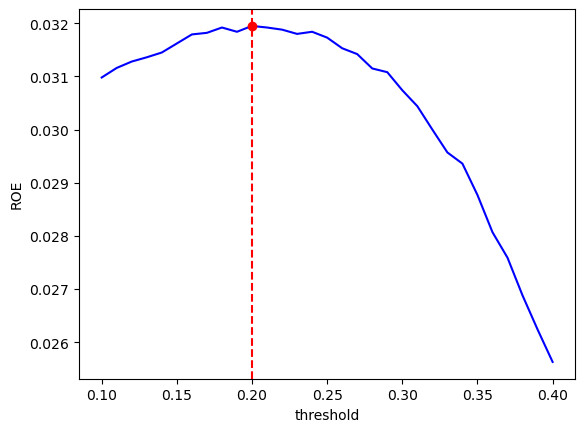

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()
sns.lineplot(x=thresholds, y=roes, color='b', markers='o')
plt.axvline(x=max_threshold, linestyle='--', color='red', label=f'Max ROE at {max_threshold:.2f}')
plt.scatter([max_threshold], [max_roe], color='red', zorder=5)
plt.xlabel("threshold")
plt.ylabel("ROE")
fig.savefig("validation set을 통한 최적 threshold 탐색.png")
plt.show()

In [9]:
DECISION_BOUNDARY=max_threshold

### Step 3. 시험 데이터(test set) 부트스트래핑을 통한 OOS(Out Of Sample) 테스트

In [10]:
def get_expected_bootstraped_roe(bootstraped_test_df, y_true, y_pred):
    earning = np.sum(bootstraped_test_df.iloc[np.where((y_pred==0)&(y_true==0))]['raw_total_pymnt'])
    recovered = np.sum(bootstraped_test_df.iloc[np.where((y_pred==0)&(y_true==1))]['raw_total_pymnt'])
    risk_free = np.sum(bootstraped_test_df.iloc[np.where(y_pred==1)]['raw_loan_amnt'])*RISK_FREE
    loan_amnt = np.sum(bootstraped_test_df['raw_loan_amnt'])
    return (earning+recovered+risk_free-loan_amnt)/loan_amnt

In [6]:
# 부트스트래핑 시행 횟수
RANDOM_SIZE=100

In [13]:
bootstraped_roes = []
for rs in range(1, RANDOM_SIZE+1):
    bootstraped_test_df = origin_test_df[160339:].sample(n=160339, replace=True, random_state=rs)
    bootstraped_test_x = bootstraped_test_df.drop(columns=['loan_status', 'raw_loan_amnt', 'raw_total_pymnt']).astype(np.float32)
    bootstraped_test_y = bootstraped_test_df['loan_status'].astype(np.float32)
    bootstraped_prob = model.predict(bootstraped_test_x)
    bootstraped_prob = bootstraped_prob.flatten()
    bootstraped_pred = np.where(bootstraped_prob>DECISION_BOUNDARY, 1, 0)
    roe = get_expected_bootstraped_roe(bootstraped_test_df=bootstraped_test_df, y_true=bootstraped_test_y, y_pred=bootstraped_pred)
    bootstraped_roes.append(round(roe, 5))
    print(f"threshold: {max_threshold:.2f}\troe: {roe:.4f}")

5011/5011 [==============================] - 3s 676us/step
threshold: 0.20	roe: 0.0315
5011/5011 [==============================] - 3s 673us/step
threshold: 0.20	roe: 0.0314
5011/5011 [==============================] - 4s 779us/step
threshold: 0.20	roe: 0.0313
5011/5011 [==============================] - 4s 825us/step
threshold: 0.20	roe: 0.0313
5011/5011 [==============================] - 4s 821us/step
threshold: 0.20	roe: 0.0314
5011/5011 [==============================] - 4s 816us/step
threshold: 0.20	roe: 0.0315
5011/5011 [==============================] - 4s 832us/step
threshold: 0.20	roe: 0.0310
5011/5011 [==============================] - 5s 1ms/step
threshold: 0.20	roe: 0.0316
5011/5011 [==============================] - 5s 1ms/step
threshold: 0.20	roe: 0.0316
5011/5011 [==============================] - 5s 1ms/step
threshold: 0.20	roe: 0.0315
5011/5011 [==============================] - 5s 999us/step
threshold: 0.20	roe: 0.0316
5011/5011 [==============================] - 4s 8

- 부트스트랩 결과 히스토그램 plot

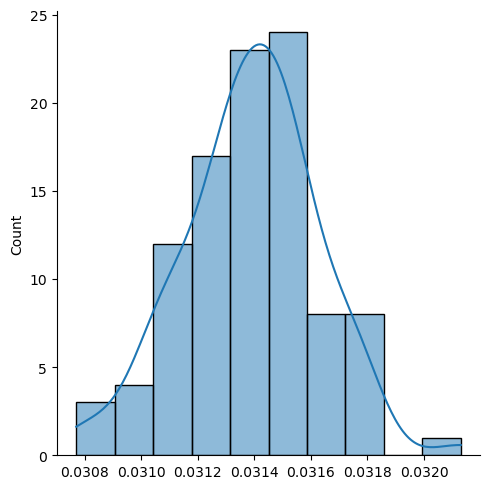

In [14]:
sns.displot(x=bootstraped_roes, bins=10, kde=True)
plt.savefig("Bootstraping한 ROE의 히스토그램.png")
plt.show()

- 신뢰 구간 도출

In [1]:
def confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
    stderr = stats.sem(data)
    interval = stderr*stats.t.ppf((1+confidence)/2, n-1)
    return np.round([mean-interval, mean+interval], 5)

In [5]:
lower_bound, upper_bound = confidence_interval(roes)
print(f'confidence interval: ({lower_bound}, {upper_bound})')

confidence interval: (0.03134, 0.03144)
